In [188]:
# Importing libraries
from random import sample
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [116]:
# Loading the dataset
data = pd.read_csv('training_v2.csv')

## Data Preprocessing
### Class Imbalance
We find that this dataset is hugely imbalanced. There are very few observations of `hospital_death` = 1 as compared to `hospital_death` = 0. Once presented with previously unseen data, this can prove to be a problem since classification algorithms might classify all the entries as `hospital_death` = 0 in order to obtain a high accuracy. 

In [117]:
# Extracting the counts for each level of the target feature
data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

### Resampling 

Resampling, as the name suggests, allows us to obtain a different sample of the data so as to ensure that both classes in our target variable are evenly distributed. Since we have almost 100,000 records in the dataset, we choose **downsampling technique** so that our dataset is reduced to something more manageable thereby also speeding up our first iteration of modeling. 

In [118]:
# Extracting the rows where hospital == 0
alive_data = data[data['hospital_death'] == 0].reset_index(drop=True)

# Generating indexes from 0 to 83798
idx = list(range(0,83798))

# Subset a sample without replacement from the indexes
random.seed(42)
subset = sample(idx, 7915)

# Subsetting the alive_data with the chosen indexes, reseting the index
alive_data = alive_data.loc[subset].reset_index(drop=True)

In [119]:
# Appending the alive_data with the observations where hospital_death == 1
new_data = alive_data.append(data[data['hospital_death'] == 1])

# Shuffling the dataset so the distribution of 0 and 1 is random throughout the dataset
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [120]:
new_data.shape

(15830, 186)

In [121]:
new_data.head(20)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,88430,2187,171,0,63.0,27.202216,1,Caucasian,M,190.0,PACU,Operating Room / Recovery,404,admit,CSICU,0.144444,0,98.2,NaN,202.0,1204.01,1,0.0,NaN,11.0,0.78,NaN,4.0,6.0,0.0,5.0,106.0,109.0,36.9,0.0,134.0,NaN,NaN,NaN,NaN,28.0,137.0,36.30,NaN,0.0,7.50,87.0,57.0,90.0,71.0,90.0,71.0,106.0,79.0,113.0,73.0,101.0,82.0,101.0,82.0,26.0,13.0,98.0,91.0,168.0,106.0,143.0,122.0,143.0,122.00,38.20,36.300,87.0,72.0,90.0,77.0,90.0,77.0,83.0,79.0,113.0,94.0,101.0,88.0,101.0,88.0,19.0,17.0,98.0,94.0,168.0,144.0,143.0,123.0,143.0,123.0,36.30,36.30,NaN,NaN,NaN,NaN,11.0,11.0,8.1,8.1,0.78,0.78,106.0,106.0,23.0,23.0,12.2,12.2,36.9,36.9,NaN,NaN,NaN,NaN,171.0,171.0,3.8,3.8,137.0,137.0,7.50,7.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
1,79169,67579,19,1,76.0,38.402118,0,Caucasian,M,177

### Split the feature variables and the target variable

In [122]:
X = new_data.drop('hospital_death', axis = 1)
y = new_data['hospital_death']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 22.3+ MB


### Missing values
This dataset contains a lot of missing values and we've employed various strategies throughout the notebook to deal with them. We first start with: 
1. **Drop rows that contain missing values greater than a 50% threshold.**
2. **Use the index of the rows in step 1 to drop the respective values from the target variable column.**

In [123]:
# Look at the row-wise percentage of missing values in X
X.isnull().mean(axis = 1)

0        0.335135
1        0.335135
2        0.394595
3        0.345946
4        0.486486
5        0.437838
6        0.578378
7        0.254054
8        0.405405
9        0.400000
10       0.432432
11       0.518919
12       0.286486
13       0.389189
14       0.102703
15       0.345946
16       0.302703
17       0.302703
18       0.367568
19       0.221622
20       0.329730
21       0.108108
22       0.372973
23       0.286486
24       0.118919
25       0.248649
26       0.145946
27       0.524324
28       0.394595
29       0.470270
           ...   
15800    0.535135
15801    0.167568
15802    0.275676
15803    0.551351
15804    0.091892
15805    0.432432
15806    0.259459
15807    0.340541
15808    0.545946
15809    0.264865
15810    0.308108
15811    0.351351
15812    0.210811
15813    0.324324
15814    0.162162
15815    0.421622
15816    0.243243
15817    0.037838
15818    0.351351
15819    0.189189
15820    0.254054
15821    0.529730
15822    0.394595
15823    0.378378
15824    0

In [124]:
# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X after dropping rows is (14636, 185)
The shape of y after dropping rows is (14636,)


### Feature Selection

We follow 2 strategies in order to reduce the number of dimensions in our dataset.
1. **Drop columns that contain missing values greater than a 75% threshold:**
> For example, the column `h1_pao2fio2ratio_min` is missing 83.5% of its data. 
2. **Drop coloumns based on manual evaluation of the data:**
> For example, drop the `id` columns since they don't provide any relevant information in predicting `hospital_death`.
> Drop the `height` and `weight` columns since they are collinear to the `bmi` column.
> Drop the `readmission_status` column since it contains all 0s. 

In [125]:
# Look at the column-wise percentage of missing values in X
row_majority_X.isnull().mean()

encounter_id                     0.000000
patient_id                       0.000000
hospital_id                      0.000000
age                              0.055411
bmi                              0.037442
elective_surgery                 0.000000
ethnicity                        0.013870
gender                           0.000410
height                           0.015646
hospital_admit_source            0.223968
icu_admit_source                 0.001093
icu_id                           0.000000
icu_stay_type                    0.000000
icu_type                         0.000000
pre_icu_los_days                 0.000000
readmission_status               0.000000
weight                           0.027603
albumin_apache                   0.503895
apache_2_diagnosis               0.010180
apache_3j_diagnosis              0.006901
apache_post_operative            0.000000
arf_apache                       0.004031
bilirubin_apache                 0.552952
bun_apache                       0

In [126]:
# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

(14636, 149)

In [127]:
# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

The shape of X after dropping columns is (14636, 142)


### Feature Transformation
1. **Transforming `BMI` from a numerical to a categorical variable**

BMI Categories | BMI Values
--- | ---
Underweight | <18.5 =0
Normal weight | 18.5–24.9 =1
Overweight | 25–29.9 =2
Obesity | BMI of 30 or greater =3

2. **Transforming `pre_icu_los_days` from a numerical to a categorical variable**

pre_icu_los_days Categories | pre_icu_los_days Values
--- | ---
'0' | <= 0
'1' | > 0 and <= 5
'2' | > 5 and <= 10
'3' | > 10 and <= 15
'4' | > 15 and <= 20
'5' | > 20 and <= 25
'6' | > 25 and <= 30
'7' | => 30

In [128]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
        x = float(x)
        if (x >= 0) and (x < 18.5) : return 'Underweight'
        elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
        elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
        else : return 'Obese'
    except ValueError:
        return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

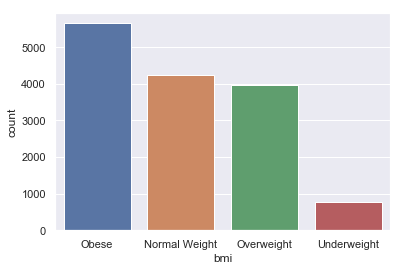

In [129]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [130]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
        x = float(x)
        if (x <= 0)                : return 'Range[- to 0]'
        elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
        elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
        elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
        elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
        elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
        elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
        else : return 'Range[> 30]'
    except ValueError:
        return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

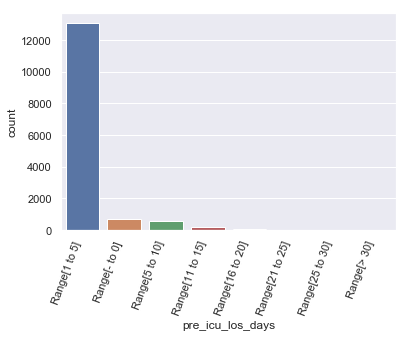

In [131]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['pre_icu_los_days'], order = final_X['pre_icu_los_days'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

### Split categorical and numerical variables

In [132]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

### Dealing with categorical variables

There are still some missing values that need to be taken care of among our categorical variables so we evaluate them in order:
1. **ethnicity** 
> Impute the missing values with 'Other/Unknown' since the dataframe already has that value.
2. **gender** 
> We observe that there are only 6 missing values. Therefore, we decide to impute values as either 'M' or 'F' based on the percentage of these 2 classes in the column. Following that, we encode the values as follows:

Value | Encoding
--- | ---
'F' | 0
'M' | 1

3. **hospital_admit_source** and **icu_admit_source**
> On evaluating the 2 columns side by side, we find that `icu_admit_source` is conveying similar information as `hospital_admit_source` and also has fewer missing values than `hospital_admit_source`. Therefore we decide to drop `hospital_admit_source` and impute the missing values of `icu_admit_source` wuth 'Unknown'.
4. **apache_3j_bodysystem** and **apache_2_bodysystem** 
> On evaluating the 2 columns side by side, we find that `apache_3j_bodysystem` is conveying similar information as `apache_2_bodysystem`. Therefore we decide to drop `apache_2_bodysystem` and impute the missing values of `apache_3j_bodysystem` with 'Unknown'.
5. **arf_apache, intubated_apache, ventilated_apache, aids, cirrhosis, diabetes_mellitus, hepatic_failure         immunosuppression, leukemia, lymphoma, solid_tumor_with_metastasis**
> Upon observation, all these variables have missing values in the same records and hence we drop those records (using the index values) from X_cat, X_num and final_y. 
6. **gcs_unable_apache** 
> This variable tells us whether the Glasgow Coma Scale was unable to be assessed due to patient sedation and is dropped because this information has already been taken care of by 3 other columns - `gcs_eyes_apache`, `gcs_motor_apache` and `gcs_verbal_apache`. 

In [133]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                               0
elective_surgery                  0
ethnicity                       203
gender                            6
hospital_admit_source          3278
icu_admit_source                 16
icu_stay_type                     0
icu_type                          0
pre_icu_los_days                  0
apache_post_operative             0
arf_apache                       59
gcs_unable_apache                89
intubated_apache                 59
ventilated_apache                59
aids                             59
cirrhosis                        59
diabetes_mellitus                59
hepatic_failure                  59
immunosuppression                59
leukemia                         59
lymphoma                         59
solid_tumor_with_metastasis      59
apache_3j_bodysystem            149
apache_2_bodysystem             149
dtype: int64

In [134]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           11324
African American     1490
Other/Unknown         667
Hispanic              624
Asian                 194
Native American       134
Name: ethnicity, dtype: int64


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


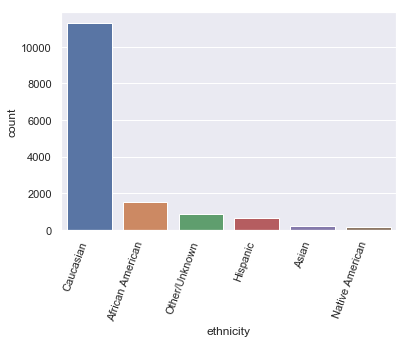

In [135]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [136]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.540602
F    0.459398
Name: gender, dtype: float64

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


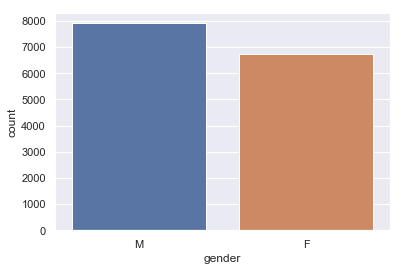

In [137]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


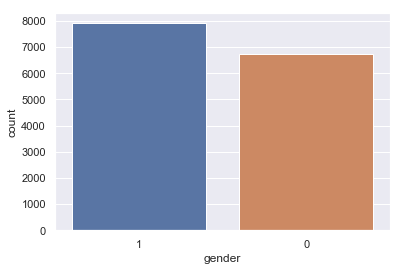

In [138]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [139]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Overweight,1,Caucasian,1,PACU,Operating Room / Recovery,admit,CSICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
1,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
2,Obese,0,Native American,0,NaN,Floor,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
4,Underweight,0,African American,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,Obese,0,Native American,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
6,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
7,Obese,0,Caucasian,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
8,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,SICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
9,Normal Weight,0,Caucasian,0,NaN,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
10,Obese,0,Caucasian,1,NaN,Accident & Emergency,admit,SICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal


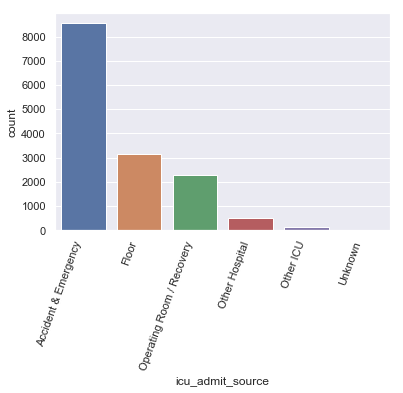

In [140]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [141]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
2,Obese,0,Native American,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
4,Underweight,0,African American,0,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
6,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
11,Obese,0,African American,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hematological,Haematologic
13,Obese,1,African American,0,Operating Room / Recovery,admit,Neuro ICU,Range[1 to 5],1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,Neurological,Neurologic
22,Underweight,0,Caucasian,0,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
26,Obese,0,Caucasian,1,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
27,Normal Weight,0,Caucasian,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[11 to 15],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
31,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
34,Normal Weight,0,Caucasian,0,Accident & Emergency,admit,Neuro ICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


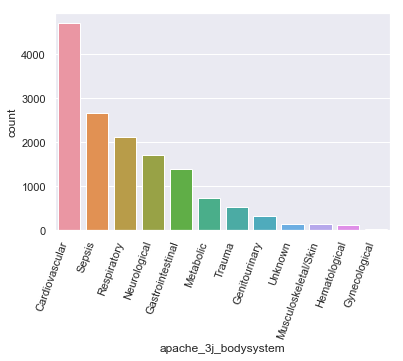

In [142]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [143]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                     59
gcs_unable_apache              89
intubated_apache               59
ventilated_apache              59
aids                           59
cirrhosis                      59
diabetes_mellitus              59
hepatic_failure                59
immunosuppression              59
leukemia                       59
lymphoma                       59
solid_tumor_with_metastasis    59
apache_3j_bodysystem            0
dtype: int64

In [144]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (14577, 22)
The shape of X_num after dropping rows is (14577, 118)
The shape of y after dropping rows is (14577,)


In [145]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                      0
gcs_unable_apache              30
intubated_apache                0
ventilated_apache               0
aids                            0
cirrhosis                       0
diabetes_mellitus               0
hepatic_failure                 0
immunosuppression               0
leukemia                        0
lymphoma                        0
solid_tumor_with_metastasis     0
apache_3j_bodysystem            0
dtype: int64

In [146]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

### Dealing with numerical variables

In [151]:
X_num_nonan = X_num.dropna(thresh=len(X_num) - 5000, axis=1)
tmp = pd.concat([X_num_nonan, X_cat], axis=1)
new_dataset = pd.get_dummies(tmp)
new_dataset.head()

,age,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,elective_surgery,gender,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,bmi_Normal Weight,bmi_Obese,bmi_Overweight,bmi_Underweight,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,icu_admit_source_Accident & Emergency,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_admit_source_Unknown,icu_stay_type_admit,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CCU-CTICU,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU,pre_icu_los_days_Range[- to 0],pre_icu_los_days_Range[1 to 5],pre_icu_los_days_Range[11 to 15],pre_icu_los_days_Range[16 to 20],pre_icu_los_days_Range[21 to 25],pre_icu_los_days_Range[25 to 30],pre_icu_los_days_Range[5 to 10],pre_icu_los_days_Range[> 30],apache_3j_bodysystem_Cardiovascular,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_3j_bodysystem_Unknown
0,63.0,202.0,1204.01,11.0,0.78,4.0,6.0,5.0,106.0,109.0,36.9,134.0,28.0,137.0,36.30,7.5,90.0,71.0,90.0,71.0,106.0,79.0,101.0,82.0,101.0,82.0,26.0,13.0,98.0,91.0,143.0,122.0,143.0,122.0,38.2,36.30,90.0,77.0,90.0,77.0,83.0,79.0,101.0,88.0,101.0,88.0,19.0,17.0,98.0,94.0,143.0,123.0,143.0,123.0,36.30,36.30,11.0,11.0,8.1,8.1,0.78,0.78,106.0,106.0,23.0,23.0,12.2,12.2,36.9,36.9,171.0,171.0,3.8,3.8,137.0,137.0,7.5,7.5,0.02,0.01,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,76.0,110.0,104.01,NaN,NaN,3.0,6.0,4.0,135.0,102.0,NaN,52.0,28.0,NaN,37.11,NaN,104.0,39.0,104.0,39.0,102.0,66.0,110.0,56.0,110.0,56.0,28.0,18.0,100.0,91.0,143.0,92.0,143.0,92.0,37.5,36.72,74.0,64.0,74.0,64.0,102.0,95.0,80.0,72.0,80.0,72.0,27.0,23.0,98.0,95.0,114.0,99.0,114.0,99.0,36.72,36.72,83.0,83.0,NaN,NaN,3.30,3.30,185.0,135.0,31.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,5.1,5.1,137.0,137.0,NaN,NaN,0.04,0.02,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,61.0,113.0,501.01,NaN,NaN,3.0,6.0,2.0,39.0,121.0,NaN,40.0,10.0,NaN,36.70,NaN,68.0,24.0,68.0,24.0,121.0,94.0,73.0,33.0,73.0,33.0,23.0

In [154]:
X_train, X_test, y_train, y_test = train_test_split(new_dataset, 
                                                    final_y, 
                                                    test_size=0.2, 
                                                    stratify=final_y, 
                                                    random_state=42)

In [155]:
# Just as a sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(11661, 141)
(11661,)
(2916, 141)
(2916,)


In [161]:
imp = Imputer(strategy="mean")
new_X_train = imp.fit_transform(X_train)
new_X_test = imp.transform(X_test)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 depth
AUC Train:  0.8872244735072903
AUC Validation:  0.6892800775268556
 
2 depth
AUC Train:  0.8855479236020984
AUC Validation:  0.6918394516668509
 
3 depth


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9518893497360321
AUC Validation:  0.740744643566988
 
4 depth


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9520612187156537
AUC Validation:  0.735397031116589
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 depth
AUC Train:  0.9736702018284564
AUC Validation:  0.7595884208372242
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 depth
AUC Train:  0.9753001992885904
AUC Validation:  0.7623002142808419
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7 depth
AUC Train:  0.9843819856246051
AUC Validation:  0.7712320325161182
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 depth
AUC Train:  0.9859801244446138
AUC Validation:  0.7673834450996488
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9 depth
AUC Train:  0.9908209609730776
AUC Validation:  0.772600513239075
 


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 depth
AUC Train:  0.9909314513260873
AUC Validation:  0.7741830395890325
 
20 depth
AUC Train:  0.9977753226327134
AUC Validation:  0.7840510134237185
 
50 depth
AUC Train:  0.999743145229685
AUC Validation:  0.7897904940220114
 
75 depth
AUC Train:  0.9999146612049838
AUC Validation:  0.7955596117071198
 


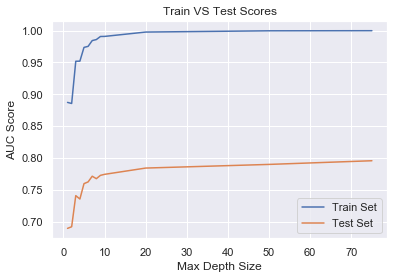

In [162]:
# Expérimentation avec différents nivraux de profondeur et évaluation de l'AUC
results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,6,7,8,9,10,20,50,75]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=44)
    #model.fit(X, y)
    model.fit(new_X_train, y_train)
    print(depth, 'depth')
    pred = model.predict(new_X_train)
    pred2 = model.predict(new_X_test)
    roc1 = roc_auc_score(y_train, pred)
    roc2 = roc_auc_score(y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Validation: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")

plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()

auto max_features
AUC:  0.7969299373981649
 
log2 max_features
AUC:  0.7970156933367636
 
0.3 max_features
AUC:  0.7965869136437699
 
0.5 max_features
AUC:  0.7943572592402024
 
0.7 max_features
AUC:  0.7952148186261898
 


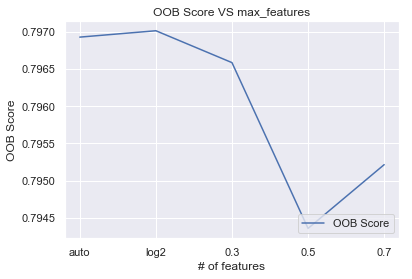

In [163]:
results = []
max_features_options = ["auto", "log2", 0.3, 0.5, 0.7]

for features in max_features_options:
    model = RandomForestClassifier(max_features=features, oob_score=True, random_state=42, max_depth=150, n_estimators=500)
    #model.fit(X, y)
    model.fit(new_X_train, y_train)
    print(features, 'max_features')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    print (" ")
    
plt.plot(max_features_options, results, label='OOB Score')
plt.xlabel('# of features')
plt.ylabel('OOB Score')
plt.title('OOB Score VS max_features')
plt.legend(loc="lower right")
plt.show()


1 min samples
AUC:  0.7911842895120487
 
2 min samples
AUC:  0.7905839979418575
 
4 min samples
AUC:  0.7934139439156161
 
5 min samples
AUC:  0.7928994082840237
 
10 min samples
AUC:  0.7904982420032587
 
15 min samples
AUC:  0.7901552182488637
 
20 min samples
AUC:  0.79041248606466
 


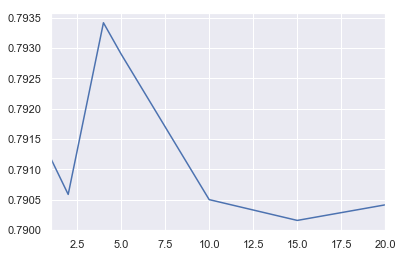

In [165]:
results = []
min_samples_leaf_options = [1, 2, 4, 5, 10, 15, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=500, max_depth=9, max_features='log2', oob_score=True, random_state=42, min_samples_leaf=min_samples)
    model.fit(new_X_train, y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot()

In [169]:
# Suite aux hyperparamètres identifiés précédemment,  
# nous allons effectuer une recherche 'gridsearch' à l'intérieur d'un petit intervalle de chaque paramètre

parameters = {"max_depth": [90, 100, 110, 120], 
            "max_features": ['log2'], 
            "min_samples_leaf": [3,4,5,6,7,8]}

model_rf = RandomForestClassifier(random_state=42, n_estimators=500)


# fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)


# Grid Search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(model_rf, param_grid=parameters, scoring=scorer)


# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(new_X_train, y_train)


# Get the estimator
best_clf = grid_fit.best_estimator_


# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(new_X_test)


# Report the scores
print("\nOptimized Model\n------")
print("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the validation data: {:.4f}".format(f1_score(y_test, best_predictions)))
print(best_clf)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



Optimized Model
------
Final accuracy score on the validation data: 0.7990
Final F-score on the validation data: 0.8023
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [172]:
model_rf = RandomForestClassifier(random_state=42, 
                                  n_estimators=500, 
                                  max_depth=90, 
                                  max_features='log2',
                                  min_samples_leaf=3,
                                  min_samples_split=2)

rf_model = model_rf.fit(new_X_train, y_train)
y_pred = rf_model.predict(new_X_test)
confusion_matrix(y_test, y_pred)

array([[1141,  310],
       [ 276, 1189]])

In [183]:
# Standardization of training and test sets
scaler = StandardScaler()
new_X_train_sc = scaler.fit_transform(new_X_train)
new_X_test_sc = scaler.transform(new_X_test)


In [184]:
def model_building(dict_params, model_obj, X_data, y_data, X_toPredict, y_toPredict):

    parameters = dict_params

    # model as an object
    model = model_obj

    # fbeta_score scoring object using make_scorer()
    scorer = make_scorer(f1_score)

    # Grid Search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(model, param_grid=dict_params, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_data, y_data)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the model
    best_predictions = best_clf.predict(X_toPredict)
    
    # Give the probability from the predictions
    best_predictions_prob = best_clf.predict_proba(X_toPredict)[:,1]
    
    # Report the scores
    print("\nOptimized Model\n------")
    print("Final accuracy score on the data: {:.4f}".format(accuracy_score(y_toPredict, best_predictions)))
    print("Final F1-score on the data: {:.4f}".format(f1_score(y_toPredict, best_predictions)))
    print(best_clf)
    
    return(best_clf, best_predictions, best_predictions_prob)


In [185]:
dict_params = {"C": [0.001, 0.01, 0.1, 1, 10 , 100, 1000]}
lr_model = LogisticRegression(random_state=42, penalty="l2")

lr_model_training, train_predictions, train_predictions_prob = model_building(dict_params=dict_params, 
               model_obj=lr_model,
               X_data=new_X_train_sc, 
               y_data=y_train,
               X_toPredict=X_train_sc,
               y_toPredict=y_train)

lr_model_validation, test_predictions, test_predictions_prob = model_building(dict_params=dict_params, 
               model_obj=lr_model,
               X_data=X_train_sc, 
               y_data=y_train,
               X_toPredict=X_test_sc,
               y_toPredict=y_test)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/je


Optimized Model
------
Final accuracy score on the data: 0.7914
Final F1-score on the data: 0.7895
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/je


Optimized Model
------
Final accuracy score on the data: 0.7973
Final F1-score on the data: 0.7959
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [186]:
parameters = {"C": [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.09]}
lr_model = LogisticRegression(random_state=42, penalty="l2")

lr_model_validation_finetuned, best_test_predictions, best_test_predictions_prob = model_building(dict_params=parameters, 
               model_obj=lr_model,
               X_data=new_X_train_sc, 
               y_data=y_train,
               X_toPredict=new_X_test_sc,
               y_toPredict=y_test)

/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/je


Optimized Model
------
Final accuracy score on the data: 0.7973
Final F1-score on the data: 0.7959
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [191]:
# Fonction pour générer la matrice de confusion et extraire la précision et recall du modèle
def conf_matrix_with_metrics(true_predictions, predictions):
    confmat = confusion_matrix(true_predictions, predictions)
    print("The Confusion Matrix:\n", confmat)
    print("Accuracy Score:", round(accuracy_score(true_predictions, predictions), 2))
    print("Precision Score:", round(precision_score(true_predictions, predictions), 2))
    print("Recall Score:", round(recall_score(true_predictions, predictions), 2))
    
conf_matrix_with_metrics(y_train, train_predictions)

The Confusion Matrix:
 [[4667 1135]
 [1297 4562]]
Accuracy Score: 0.79
Precision Score: 0.8
Recall Score: 0.78


/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


age                              0.012662
apache_2_diagnosis               0.008688
apache_3j_diagnosis              0.014616
bun_apache                       0.012928
creatinine_apache                0.010605
gcs_eyes_apache                  0.018855
gcs_motor_apache                 0.007586
gcs_verbal_apache                0.046230
glucose_apache                   0.007143
heart_rate_apache                0.011655
hematocrit_apache                0.008396
map_apache                       0.008937
resprate_apache                  0.008335
sodium_apache                    0.007691
temp_apache                      0.008684
wbc_apache                       0.007017
d1_diasbp_max                    0.005687
d1_diasbp_min                    0.008558
d1_diasbp_noninvasive_max        0.008225
d1_diasbp_noninvasive_min        0.006634
d1_heartrate_max                 0.016321
d1_heartrate_min                 0.009482
d1_mbp_max                       0.007192
d1_mbp_min                       0

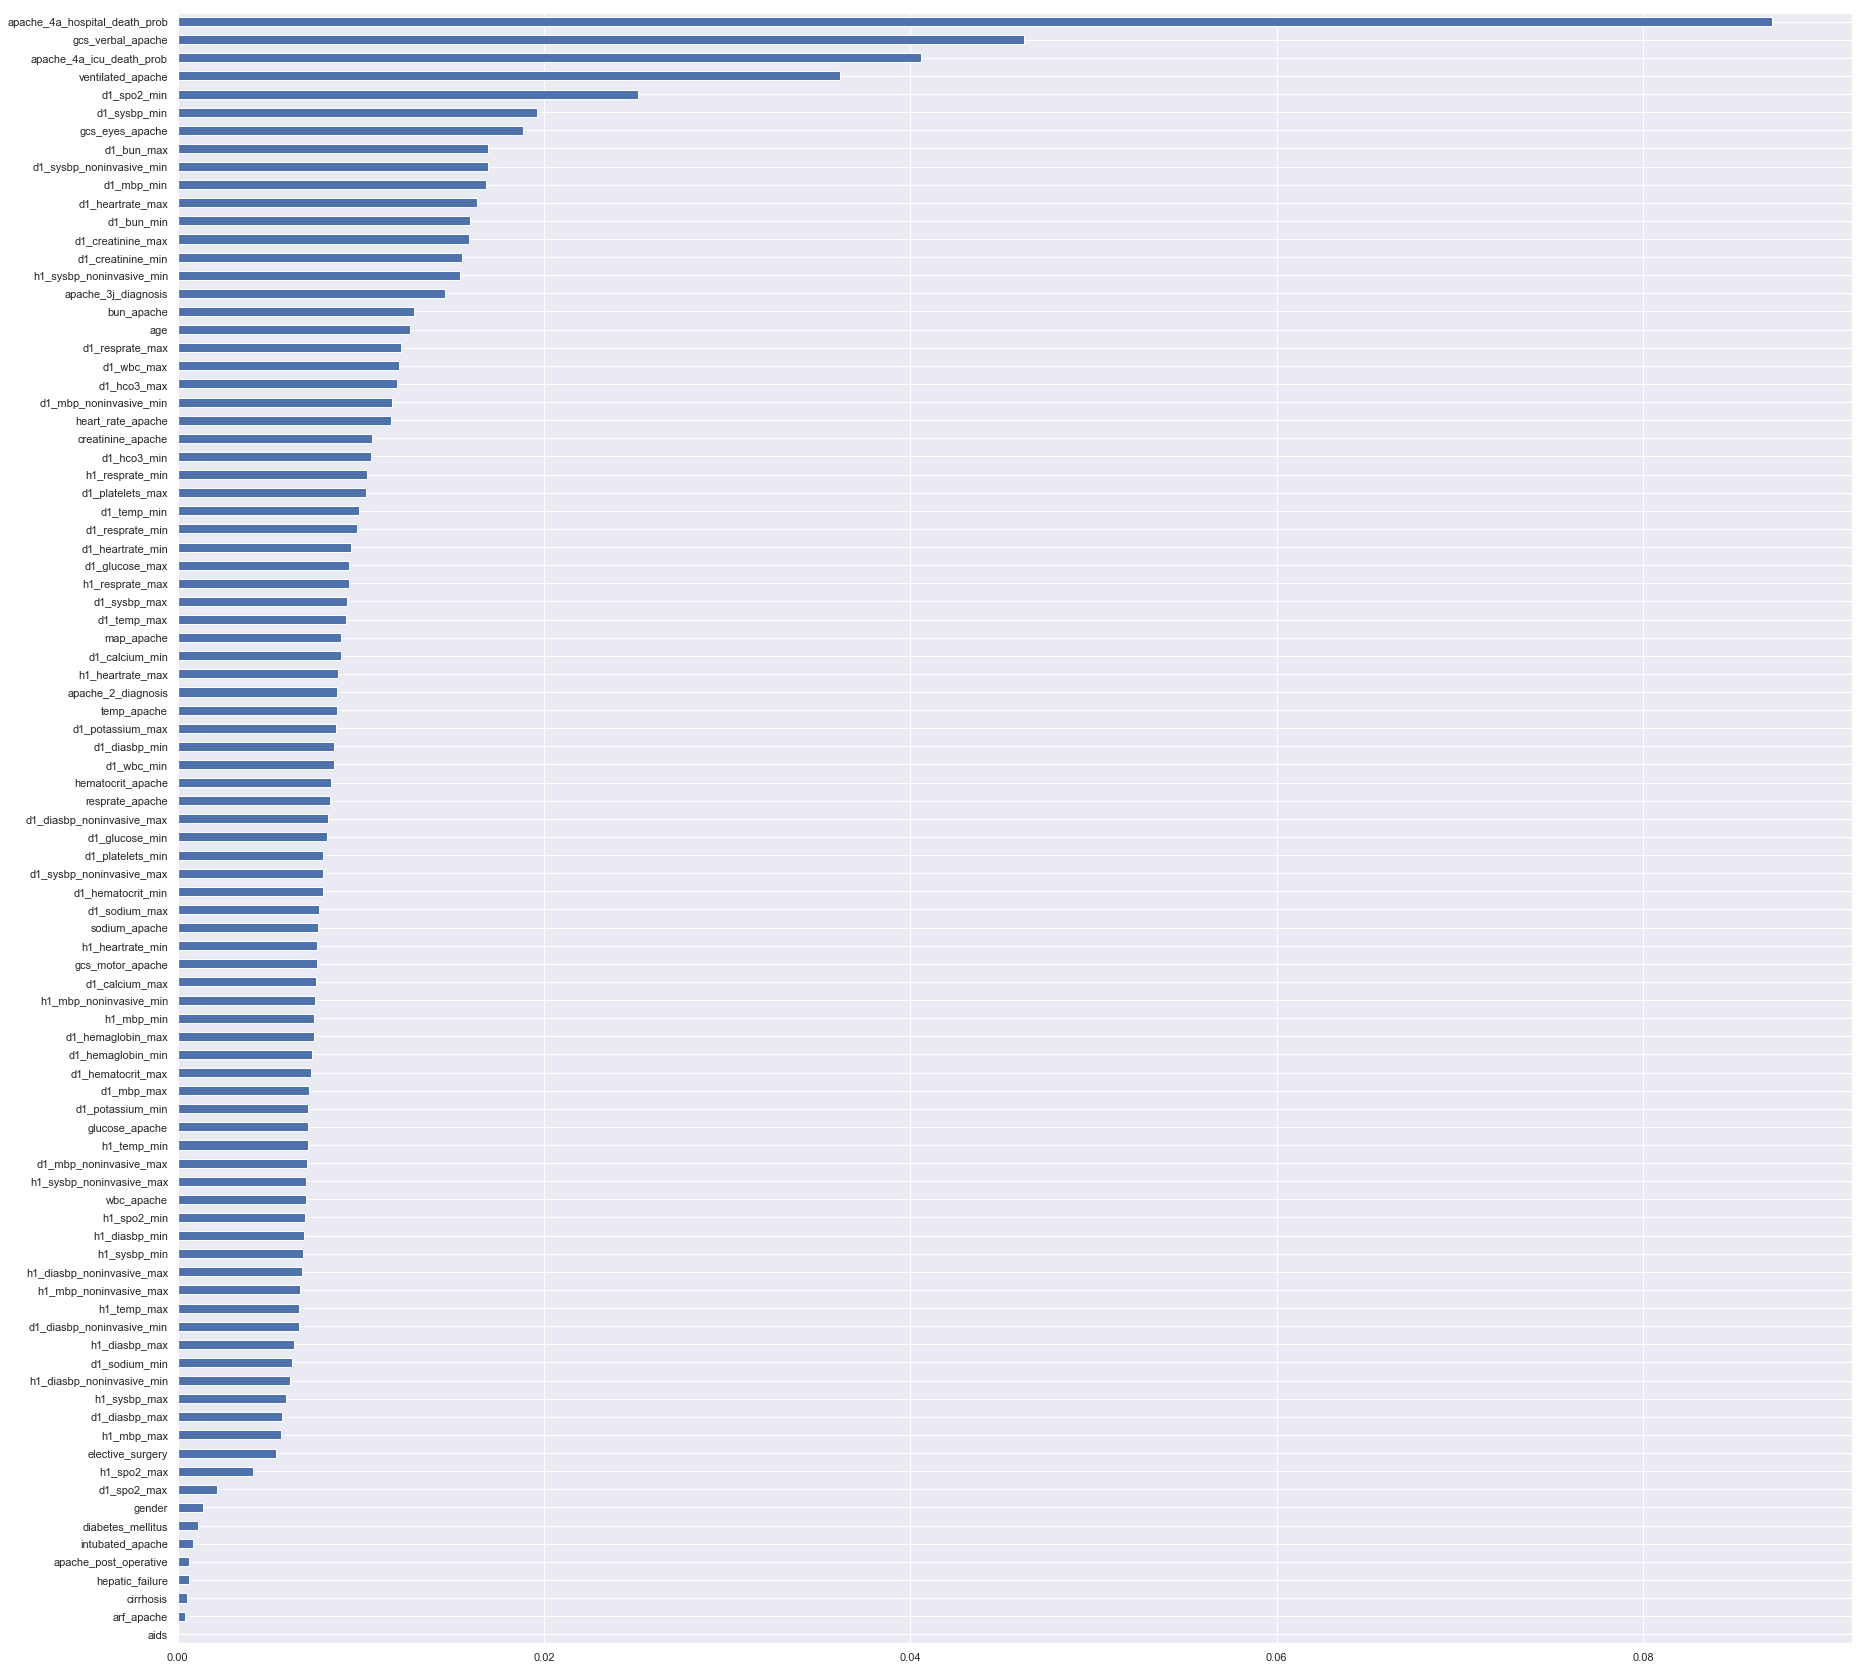

In [204]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(new_X_train, y_train)

# Extracting feature importances from our model
feature_importances = pd.Series(model_rf.feature_importances_, index=new_dataset.columns)

sub_feature_importances = feature_importances[:90]
print(sub_feature_importances)


sub_feature_importances.sort_values(inplace=True)
sub_feature_importances.plot(kind='barh', figsize=(30,30))

In [193]:
new_dataset.columns

Index(['age', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_eyes_apache', 'gcs_motor_apache',
       'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache',
       ...
       'apache_3j_bodysystem_Genitourinary',
       'apache_3j_bodysystem_Gynecological',
       'apache_3j_bodysystem_Hematological', 'apache_3j_bodysystem_Metabolic',
       'apache_3j_bodysystem_Musculoskeletal/Skin',
       'apache_3j_bodysystem_Neurological', 'apache_3j_bodysystem_Respiratory',
       'apache_3j_bodysystem_Sepsis', 'apache_3j_bodysystem_Trauma',
       'apache_3j_bodysystem_Unknown'],
      dtype='object', length=141)